In [1]:
import os
data_folder = os.path.join(os.path.expanduser("~"), "Data", "cifar-10-batches-py")
batch1_filename = os.path.join(data_folder, "data_batch_1")

In [2]:
import pickle
# Bigfix thanks to: http://stackoverflow.com/questions/11305790/pickle-incompatability-of-numpy-arrays-between-python-2-and-3
def unpickle(filename):
    with open(filename, 'rb') as fo:
        return pickle.load(fo, encoding='latin1')

In [3]:
batch1 = unpickle(batch1_filename)

In [4]:
image_index = 100
image = batch1['data'][image_index]

In [5]:
image = image.reshape((32,32, 3), order='F')
import numpy as np
image = np.rot90(image, -1)

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

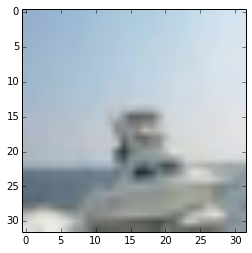

In [7]:
plt.imshow(image)

##Application

In [10]:
import numpy as np
batches = []
for i in range(1, 6):
    batch_filename = os.path.join(data_folder, "data_batch_{}".format(i))
    batches.append(unpickle(batch1_filename))
    break    #IMPORTANT -- see chapter for explanation of this line

In [9]:
X = np.vstack([batch['data'] for batch in batches])

In [11]:
X = np.array(X) / X.max()
X = X.astype(np.float32)

In [12]:
from sklearn.preprocessing import OneHotEncoder
y = np.hstack(batch['labels'] for batch in batches).flatten()
y = OneHotEncoder().fit_transform(y.reshape(y.shape[0],1)).todense()
y = y.astype(np.float32)

In [15]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [16]:
X_train = X_train.reshape(-1, 3, 32, 32)
X_test = X_test.reshape(-1, 3, 32, 32)

In [17]:
from lasagne import layers
layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ]

In [19]:
from nolearn.lasagne import NeuralNet
from lasagne.nonlinearities import sigmoid, softmax
nnet = NeuralNet(layers=layers,
                 input_shape=(None, 3, 32, 32),
                 conv1_num_filters=32,
                 conv1_filter_size=(3, 3),
                 conv2_num_filters=64,
                 conv2_filter_size=(2, 2),
                 conv3_num_filters=128,
                 conv3_filter_size=(2, 2),
                 pool1_ds=(2,2),
                 pool2_ds=(2,2),
                 pool3_ds=(2,2),
                 hidden4_num_units=500,
                 hidden5_num_units=500,
                 output_num_units=10,
                 output_nonlinearity=softmax,
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 regression=True,
                 max_epochs=3,
                 verbose=1)

In [20]:
nnet.fit(X_train, y_train)

  input             	(None, 3, 32, 32)   	produces    3072 outputs
  conv1             	(None, 32, 30, 30)  	produces   28800 outputs
  pool1             	(None, 32, 15, 15)  	produces    7200 outputs
  conv2             	(None, 64, 14, 14)  	produces   12544 outputs
  pool2             	(None, 64, 7, 7)    	produces    3136 outputs
  conv3             	(None, 128, 6, 6)   	produces    4608 outputs
  pool3             	(None, 128, 3, 3)   	produces    1152 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.090018  |    0.090022  |     0.999963  |             |  103.9s
     2  |    0.089988  |    0.090000  |     0.999858  |             |  103.8s
     3  |    0.089961

/usr/local/lib/python3.4/dist-packages/Lasagne-0.1dev-py3.4.egg/lasagne/init.py:30: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


NeuralNet(X_tensor_type=<function tensor4 at 0x7fe55b73a0d0>,
     batch_iterator_test=<nolearn.lasagne.BatchIterator object at 0x7fe559e70710>,
     batch_iterator_train=<nolearn.lasagne.BatchIterator object at 0x7fe559e706d8>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, eval_size=0.2,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 3, 32, 32),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=3, more_params={},
     objective=<class 'lasagne.objectives.Objective'>

In [21]:
from sklearn.metrics import f1_score
y_pred = nnet.predict(X_test)
print(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

0.0364246254873


/usr/local/lib/python3.4/dist-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
